In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print("Libraries loaded. Seed set to", SEED)

Libraries loaded. Seed set to 42


In [3]:
df = pd.read_csv("C:/Users/Administrator/Desktop/Smart Energy Consumption Forecasting/cleaned_preprocessed_energy_data.csv")

In [4]:
print("Loaded:", "C:/Users/Administrator/Desktop/Smart Energy Consumption Forecasting/cleaned_preprocessed_energy_data.csv")
print("Initial shape:", df.shape)
print("Columns:", df.columns.tolist())

Loaded: C:/Users/Administrator/Desktop/Smart Energy Consumption Forecasting/cleaned_preprocessed_energy_data.csv
Initial shape: (17477, 13)
Columns: ['datetime', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'hour', 'day', 'month', 'year', 'day_of_week']


In [5]:
if 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'])
else:
    raise ValueError("This script expects a 'datetime' column in the CSV.")

In [6]:
df = df.sort_values('datetime').reset_index(drop=True)
display(df.head())
print("Date range:", df['datetime'].min(), "to", df['datetime'].max())

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day,month,year,day_of_week
0,2006-12-16 17:00:00,1.000000,0.581227,0.173773,1.000000,0.0,0.019744,0.883552,17,16,12,2006,5
1,2006-12-16 18:00:00,0.873211,0.119906,0.169369,0.885056,0.0,0.251269,0.883843,18,16,12,2006,5
2,2006-12-16 19:00:00,0.814863,0.136010,0.076239,0.819695,0.0,0.053621,0.874236,19,16,12,2006,5
3,2006-12-16 20:00:00,0.781744,0.104629,0.134218,0.784730,0.0,0.000000,0.879476,20,16,12,2006,5
4,2006-12-16 21:00:00,0.728393,0.109480,0.347556,0.732878,0.0,0.015587,0.902183,21,16,12,2006,5


Date range: 2006-12-16 17:00:00 to 2008-12-13 21:00:00


In [7]:
df.replace('?', np.nan, inplace=True)

numeric_cols = [c for c in df.columns if c not in ['datetime']]
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

In [8]:
primary_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']
for c in primary_cols:
    if c not in df.columns:
        raise ValueError(f"Expected column '{c}' not found.")
df.dropna(subset=primary_cols, inplace=True)
df = df.reset_index(drop=True)
print("After cleaning shape:", df.shape)

After cleaning shape: (17415, 13)


In [9]:
display(df.describe().T)

,count,mean,min,25%,50%,75%,max,std
datetime,17415,2007-12-16 14:35:17.002583808,2006-12-16 17:00:00,2007-06-18 15:30:00,2007-12-17 02:00:00,2008-06-15 11:30:00,2008-12-13 21:00:00,NaN
Global_active_power,17415.0,0.236898,0.0,0.03758,0.154159,0.367856,1.0,0.237772
Global_reactive_power,17415.0,0.236685,0.0,0.104009,0.186901,0.30685,1.0,0.193031
Voltage,17415.0,0.541354,0.0,0.415296,0.557358,0.679144,1.0,0.206719
Global_intensity,17415.0,0.234981,0.0,0.037349,0.153171,0.362962,1.0,0.236279
Sub_metering_1,17415.0,0.063108,0.0,0.0,0.0,0.0,1.0,0.185743
Sub_metering_2,17415.0,0.053453,0.0,0.0,0.01247,0.022446,1.0,0.162565
Sub_metering_3,17415.0,0.310904,0.0,0.0,0.079476,0.684716,1.0,0.378205
hour,17415.0,11.505197,0.0,6.0,12.0,18.0,23.0,6.923408
day,17415.0,15.696296,1.0,8.0,16.0,23.0,31.0,8.802018


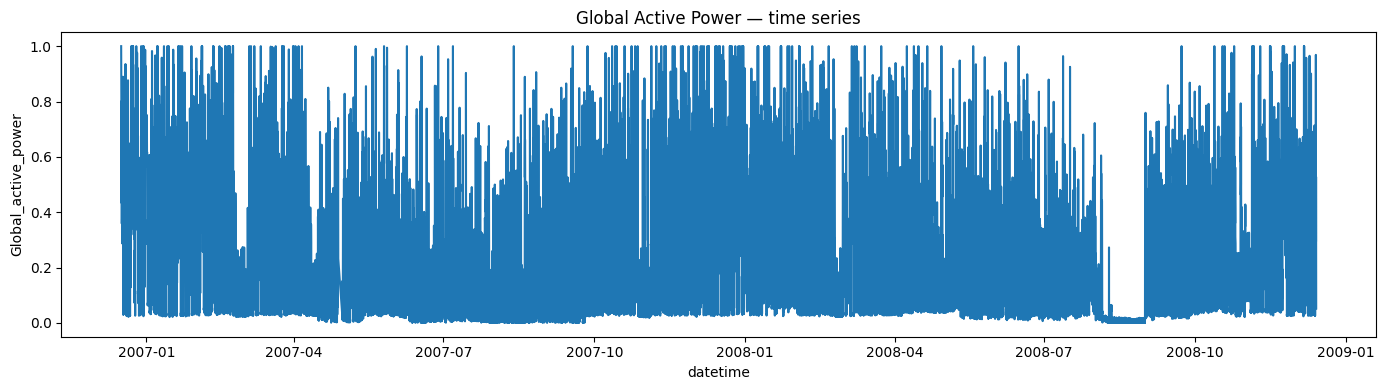

In [10]:
plt.figure(figsize=(14,4))
plt.plot(df['datetime'], df['Global_active_power'])
plt.title("Global Active Power — time series")
plt.xlabel("datetime")
plt.ylabel("Global_active_power")
plt.tight_layout()
plt.show()

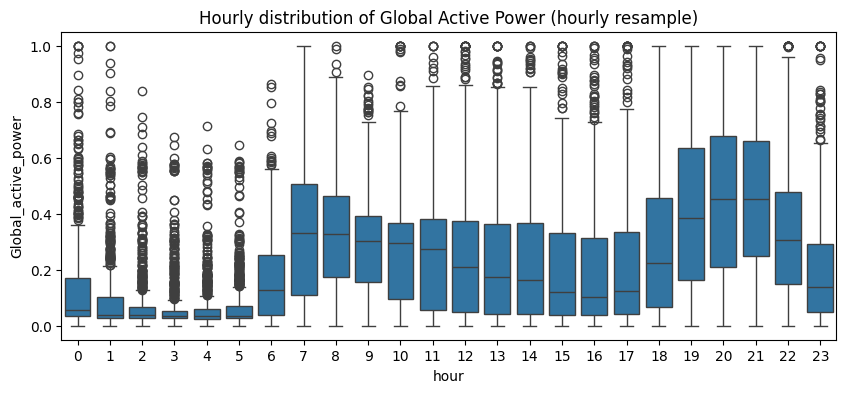

In [11]:
hourly = df.set_index('datetime').resample('h').mean().copy()
hourly['hour'] = hourly.index.hour
plt.figure(figsize=(10,4))
sns.boxplot(x='hour', y='Global_active_power', data=hourly.reset_index())
plt.title("Hourly distribution of Global Active Power (hourly resample)")
plt.show()

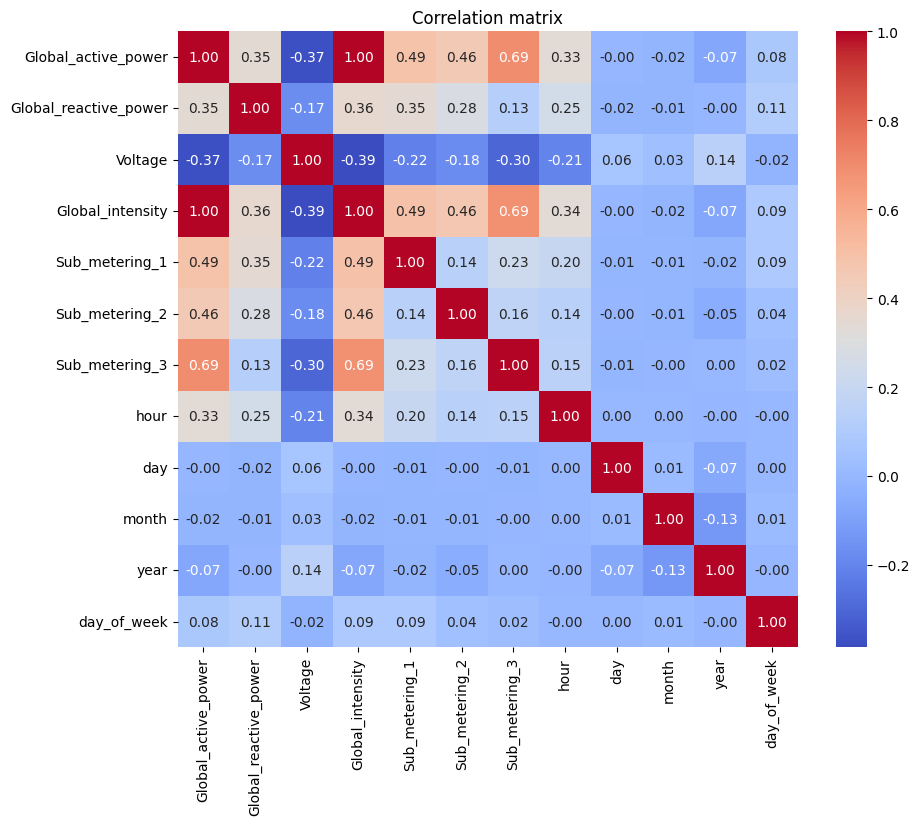

In [12]:
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation matrix")
plt.show()

In [13]:
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
df['day_of_week'] = df['datetime'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

In [14]:
hourly_df = df.set_index('datetime').resample('h').mean()
hourly_df['roll_3h'] = hourly_df['Global_active_power'].rolling(window=3, min_periods=1).mean()
hourly_df['roll_6h'] = hourly_df['Global_active_power'].rolling(window=6, min_periods=1).mean()
hourly_df['roll_12h'] = hourly_df['Global_active_power'].rolling(window=12, min_periods=1).mean()
hourly_df['lag_1h'] = hourly_df['Global_active_power'].shift(1)
hourly_df['lag_2h'] = hourly_df['Global_active_power'].shift(2)
hourly_df['lag_3h'] = hourly_df['Global_active_power'].shift(3)
# backfill small gaps introduced by shifts
hourly_df.bfill(inplace=True)

In [15]:
# Convert datetime to hourly floor
df['datetime_hour'] = df['datetime'].dt.floor('h')

# Calculate hourly features
hourly_feats = df.set_index('datetime').resample('h').mean()

# Rolling windows
hourly_feats['roll_3']  = hourly_feats['Global_active_power'].rolling(3).mean()
hourly_feats['roll_6']  = hourly_feats['Global_active_power'].rolling(6).mean()
hourly_feats['roll_12'] = hourly_feats['Global_active_power'].rolling(12).mean()

# Lag features
hourly_feats['lag_1'] = hourly_feats['Global_active_power'].shift(1)
hourly_feats['lag_2'] = hourly_feats['Global_active_power'].shift(2)
hourly_feats['lag_3'] = hourly_feats['Global_active_power'].shift(3)

# Cleanup missing values in hourly_feats
hourly_feats = hourly_feats.bfill()

# Merge safely
df = df.merge(hourly_feats[['roll_3','roll_6','roll_12','lag_1','lag_2','lag_3']],
              left_on='datetime_hour',
              right_index=True,
              how='left')

# After merging, fill small gaps from merging
df[['roll_3','roll_6','roll_12','lag_1','lag_2','lag_3']] = \
df[['roll_3','roll_6','roll_12','lag_1','lag_2','lag_3']].bfill()

print("Feature engineering completed successfully!")


Feature engineering completed successfully!


In [16]:

display(df[['datetime','Global_active_power','hour','day_of_week','roll_3','lag_1']].head())

,datetime,Global_active_power,hour,day_of_week,roll_3,lag_1
0,2006-12-16 17:00:00,1.000000,17,5,0.896025,1.000000
1,2006-12-16 18:00:00,0.873211,18,5,0.896025,1.000000
2,2006-12-16 19:00:00,0.814863,19,5,0.896025,0.873211
3,2006-12-16 20:00:00,0.781744,20,5,0.823273,0.814863
4,2006-12-16 21:00:00,0.728393,21,5,0.775000,0.781744


In [17]:
feature_cols = [
    'Global_reactive_power','Voltage','Global_intensity',
    'Sub_metering_1','Sub_metering_2','Sub_metering_3',
    'hour','day_of_week','is_weekend',
    'roll_3','roll_6','roll_12','lag_1','lag_2','lag_3'
]

In [18]:
df_model = df.dropna(subset=feature_cols + ['Global_active_power']).copy()
print("Modeling dataframe shape:", df_model.shape)

X_all = df_model[feature_cols].copy()
y_all = df_model['Global_active_power'].copy()


Modeling dataframe shape: (17415, 21)


In [19]:
split_idx = int(len(df_model) * 0.8)
X_train = X_all.iloc[:split_idx].copy()
X_test  = X_all.iloc[split_idx:].copy()
y_train = y_all.iloc[:split_idx].copy()
y_test  = y_all.iloc[split_idx:].copy()

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (13932, 15) Test shape: (3483, 15)


RandomForest -> MAE: 0.003119, RMSE: 0.004380, R2: 0.999601


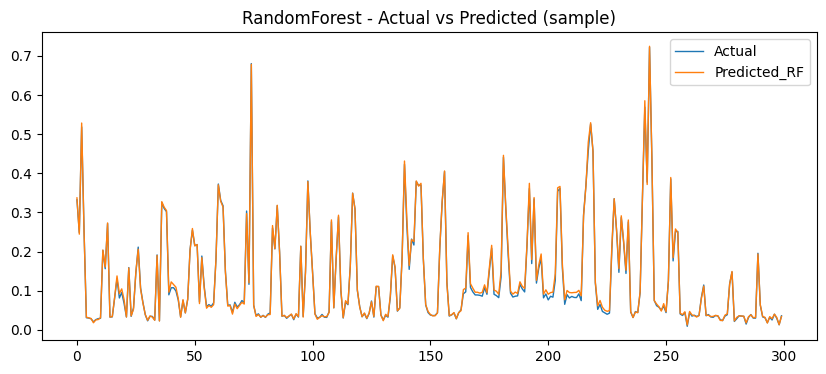

In [20]:
rf = RandomForestRegressor(n_estimators=100, random_state=SEED, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

def print_metrics(y_true, y_pred, tag="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)** 0.5
    r2 = r2_score(y_true, y_pred)
    print(f"{tag} -> MAE: {mae:.6f}, RMSE: {rmse:.6f}, R2: {r2:.6f}")
    return mae, rmse, r2

print_metrics(y_test, pred_rf, tag="RandomForest")

plt.figure(figsize=(10,4))
plt.plot(y_test.values[:300], label='Actual', linewidth=1)
plt.plot(pred_rf[:300], label='Predicted_RF', linewidth=1)
plt.title("RandomForest - Actual vs Predicted (sample)")
plt.legend()
plt.show()

XGBoost -> MAE: 0.003854, RMSE: 0.005498, R2: 0.999372


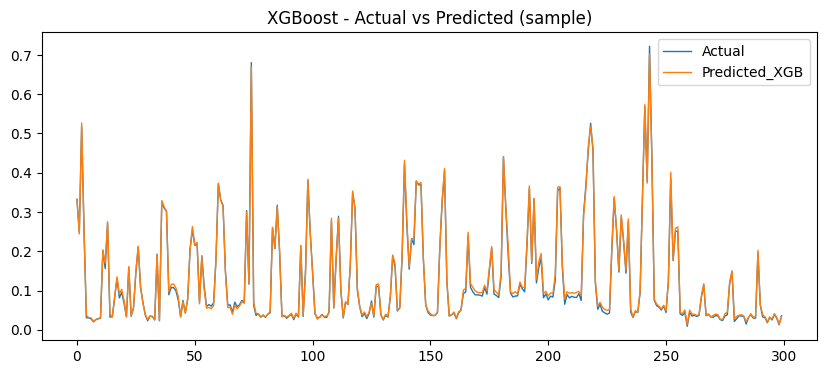

In [21]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    verbosity=0,
    n_jobs=-1
)

# Old XGBoost versions only support this simple fit:
xgb.fit(X_train, y_train)

# Predict
pred_xgb = xgb.predict(X_test)

# Metrics
print_metrics(y_test, pred_xgb, tag="XGBoost")

# Plot
plt.figure(figsize=(10,4))
plt.plot(y_test.values[:300], label='Actual', linewidth=1)
plt.plot(pred_xgb[:300], label='Predicted_XGB', linewidth=1)
plt.title("XGBoost - Actual vs Predicted (sample)")
plt.legend()
plt.show()


In [22]:
hourly_seq = hourly_df.copy()
hourly_seq['hour'] = hourly_seq.index.hour
hourly_seq['day_of_week'] = hourly_seq.index.dayofweek
hourly_seq['is_weekend'] = hourly_seq['day_of_week'].isin([5,6]).astype(int)

lstm_features = ['Global_active_power','roll_3h','roll_6h','roll_12h','lag_1h','lag_2h','lag_3h','hour','day_of_week','is_weekend']
hourly_seq = hourly_seq[lstm_features].dropna()
hourly_seq = hourly_seq.rename(columns={'roll_3h':'roll_3','roll_6h':'roll_6','roll_12h':'roll_12','lag_1h':'lag_1','lag_2h':'lag_2','lag_3h':'lag_3'})

scaler = MinMaxScaler()
scaled_vals = scaler.fit_transform(hourly_seq.values)
scaled_df = pd.DataFrame(scaled_vals, index=hourly_seq.index, columns=hourly_seq.columns)

split_idx_seq = int(len(scaled_df) * 0.8)
train_seq = scaled_df.iloc[:split_idx_seq]
test_seq  = scaled_df.iloc[split_idx_seq:]

In [23]:
def create_sequences(data, seq_len=24):
    """
    data: pandas DataFrame scaled
    seq_len: number of timesteps (e.g., 24 hours)
    returns: X (num_samples, seq_len, num_features), y (num_samples,)
    """
    X, y = [], []
    arr = data.values
    for i in range(len(arr) - seq_len):
        X.append(arr[i:i+seq_len])
        y.append(arr[i+seq_len, 0])  # target is first column (Global_active_power)
    return np.array(X), np.array(y)

SEQ_LEN = 24   # use past 24 hours to predict next hour
X_train_lstm, y_train_lstm = create_sequences(train_seq, SEQ_LEN)
X_test_lstm,  y_test_lstm  = create_sequences(test_seq, SEQ_LEN)

print("LSTM shapes:", X_train_lstm.shape, y_train_lstm.shape, X_test_lstm.shape, y_test_lstm.shape)

LSTM shapes: (13957, 24, 10) (13957,) (3472, 24, 10) (3472,)


In [ ]:
tf.keras.backend.clear_session()
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LEN, X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train_lstm, y_train_lstm,
    validation_split=0.1,
    epochs=30,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 128)             │          71,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,689 (479.25 KB)

 Trainable params: 122,689 (479.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
393/393 - 15s - 38ms/step - loss: 0.0420 - mae: 0.1565 - val_loss: 0.0211 - val_mae: 0.1052
Epoch 2/30
393/393 - 24s - 61ms/step - loss: 0.0287 - mae: 0.1237 - val_loss: 0.0199 - val_mae: 0.0985
Epoch 3/30
393/393 - 14s - 36ms/step - loss: 0.0258 - mae: 0.1147 - val_loss: 0.0198 - val_mae: 0.0978
Epoch 4/30
393/393 - 12s - 31ms/step - loss: 0.0248 - mae: 0.1122 - val_loss: 0.0205 - val_mae: 0.0996
Epoch 5/30
393/393 - 9s - 24ms/step - loss: 0.0241 - mae: 0.1101 - val_loss: 0.0207 - val_mae: 0.0987
Epoch 6/30
393/393 - 10s - 25ms/step - loss: 0.0237 - mae: 0.1085 - val_loss: 0.0203 - val_mae: 0.0998
Epoch 7/30


109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
LSTM -> MAE: 0.086896, RMSE: 0.127436, R2: 0.662919


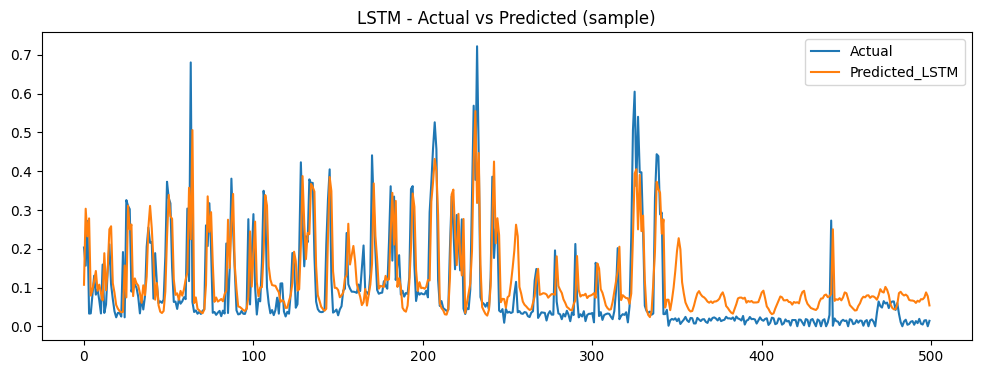

In [54]:
pred_lstm_scaled = model.predict(X_test_lstm)

zeros = np.zeros((pred_lstm_scaled.shape[0], scaled_df.shape[1]-1))
pred_lstm_full = np.hstack([pred_lstm_scaled, zeros])
pred_lstm_inv = scaler.inverse_transform(pred_lstm_full)[:,0]

y_test_full = np.hstack([y_test_lstm.reshape(-1,1), zeros])
y_test_inv = scaler.inverse_transform(y_test_full)[:,0]

print_metrics(y_test_inv, pred_lstm_inv, tag="LSTM")

plt.figure(figsize=(12,4))
plt.plot(y_test_inv[:500], label='Actual')
plt.plot(pred_lstm_inv[:500], label='Predicted_LSTM')
plt.title("LSTM - Actual vs Predicted (sample)")
plt.legend()
plt.show()

In [55]:
rf_metrics = print_metrics(y_test, pred_rf, tag="RandomForest")
xgb_metrics = print_metrics(y_test, pred_xgb, tag="XGBoost")

lstm_metrics = print_metrics(y_test_inv, pred_lstm_inv, tag="LSTM (rescaled)")

summary = pd.DataFrame({
    'Model':['RandomForest','XGBoost','LSTM'],
    'MAE':[rf_metrics[0], xgb_metrics[0], lstm_metrics[0]],
    'RMSE':[rf_metrics[1], xgb_metrics[1], lstm_metrics[1]],
    'R2':[rf_metrics[2], xgb_metrics[2], lstm_metrics[2]]
})
display(summary)

RandomForest -> MAE: 0.003119, RMSE: 0.004380, R2: 0.999601
XGBoost -> MAE: 0.003854, RMSE: 0.005498, R2: 0.999372
LSTM (rescaled) -> MAE: 0.086896, RMSE: 0.127436, R2: 0.662919


,Model,MAE,RMSE,R2
0,RandomForest,0.003119,0.004380,0.999601
1,XGBoost,0.003854,0.005498,0.999372
2,LSTM,0.086896,0.127436,0.662919


In [56]:
import joblib
joblib.dump(xgb, "xgb_energy_model.joblib")
joblib.dump(rf, "rf_energy_model.joblib")
joblib.dump(scaler, "scaler_hourly.joblib")
print("Saved model/artifact files to working directory.")

Saved model/artifact files to working directory.
